In [7]:
# LCC für layer selection
library(InfoWalkR)
library(ggplot2)
library(tidyr)
library(igraph)

Warning message:
“vorhergehender Import ‘gridExtra::combine’ durch ‘dplyr::combine’ während des Ladens von ‘InfoWalkR’ ersetzt”
Warning message:
“vorhergehender Import ‘dplyr::as_data_frame’ durch ‘igraph::as_data_frame’ während des Ladens von ‘InfoWalkR’ ersetzt”
Warning message:
“vorhergehender Import ‘dplyr::groups’ durch ‘igraph::groups’ während des Ladens von ‘InfoWalkR’ ersetzt”
Warning message:
“vorhergehender Import ‘dplyr::union’ durch ‘igraph::union’ während des Ladens von ‘InfoWalkR’ ersetzt”

Attache Paket: ‘igraph’


Das folgende Objekt ist maskiert ‘package:tidyr’:

    crossing


Die folgenden Objekte sind maskiert von ‘package:stats’:

    decompose, spectrum


Das folgende Objekt ist maskiert ‘package:base’:

    union




In [ ]:
#read in Network
path <- "/Users/paulinestaiber/Documents/Network/Pauline_Praktikum/Data/raw/multiplex_InfoWalkR/"
graph_list = read_graphs_from_folder(path)

graph_list
#remove layers:
graph_list$coex_ITI <- NULL
graph_list$coex_LVR <- NULL
graph_list$coex_MSG <- NULL
graph_list$coex_LCL <- NULL
graph_list$coex_UTR <- NULL
graph_list$reactome_copathway <- NULL

graph_list 

$`co-essential`
IGRAPH 82f4d6c UN-- 3483 68813 -- 
+ attr: name (v/c)
+ edges from 82f4d6c (vertex names):
 [1] TSC1     --TSC2     NDUFA8   --NDUFS5   ATIC     --PAICS   
 [4] TADA1    --TAF5L    NDUFA8   --NDUFV2   TADA2B   --TAF5L   
 [7] EARS2    --MRPS6    SUPT20H  --TAF5L    TADA1    --SUPT20H 
[10] MRPS6    --MRPS24   MRPS6    --MRPL43   CAD      --UMPS    
[13] KIDINS220--XPR1     EARS2    --LARS2    NDUFS1   --NDUFS5  
[16] TADA2B   --SUPT20H  EARS2    --TWNK     GART     --PAICS   
[19] NDUFC1   --NDUFV2   NDUFB3   --NDUFS5   FARS2    --LARS2   
[22] NDUFA8   --NDUFA11  MARS2    --MRPS11   UBA5     --UFM1    
+ ... omitted several edges

$coex_ADS
IGRAPH 0d33e75 UN-- 7737 66738 -- 
+ attr: name (v/c)
+ edges from 0d33e75 (vertex names):
 [1] POLDIP2 --HCCS     KLHL13  --TSPOAP1  POLDIP2 --GDE1     ARHGAP33--REX1BD  
 [5] WDR54   --OSBPL7   KDM7A   --IFRD1    AK2     --COX10    TSPOAP1 --ARHGAP44
 [9] KIAA0100--NADK     KLHL13  --ADAM22   TMEM98  --CYB561   GAS7    --CYB561  


$`co-essential`
IGRAPH 82f4d6c UN-- 3483 68813 -- 
+ attr: name (v/c)
+ edges from 82f4d6c (vertex names):
 [1] TSC1     --TSC2     NDUFA8   --NDUFS5   ATIC     --PAICS   
 [4] TADA1    --TAF5L    NDUFA8   --NDUFV2   TADA2B   --TAF5L   
 [7] EARS2    --MRPS6    SUPT20H  --TAF5L    TADA1    --SUPT20H 
[10] MRPS6    --MRPS24   MRPS6    --MRPL43   CAD      --UMPS    
[13] KIDINS220--XPR1     EARS2    --LARS2    NDUFS1   --NDUFS5  
[16] TADA2B   --SUPT20H  EARS2    --TWNK     GART     --PAICS   
[19] NDUFC1   --NDUFV2   NDUFB3   --NDUFS5   FARS2    --LARS2   
[22] NDUFA8   --NDUFA11  MARS2    --MRPS11   UBA5     --UFM1    
+ ... omitted several edges

$coex_ADS
IGRAPH 0d33e75 UN-- 7737 66738 -- 
+ attr: name (v/c)
+ edges from 0d33e75 (vertex names):
 [1] POLDIP2 --HCCS     KLHL13  --TSPOAP1  POLDIP2 --GDE1     ARHGAP33--REX1BD  
 [5] WDR54   --OSBPL7   KDM7A   --IFRD1    AK2     --COX10    TSPOAP1 --ARHGAP44
 [9] KIAA0100--NADK     KLHL13  --ADAM22   TMEM98  --CYB561   GAS7    --CYB561  


In [19]:
# load seed genes
gene_set <- readLines("/Users/paulinestaiber/Documents/Network/Pauline_Praktikum/disease_genes.txt")


In [ ]:
# show function of infowalk package
lcc_based_network_selection

In [ ]:
#Adaptation of the lcc_based_network_selection function
lcc_based_network_selection_adapted = function (graph_list, gene_set, trial = 1000, randomization = "dpr_binned", 
    alpha = 0.05) 
{
    results = list()
    for (graph_name in names(graph_list)) {
        graph = graph_list[[graph_name]]
        observed_lcc_size = calculate_lcc(graph, gene_set)
        lcc_size_distribution = calc_lcc_distribution_random_expectation(graph, 
            gene_set, trial, randomization)
        mean_lcc = mean(lcc_size_distribution)
        sd_lcc = sd(lcc_size_distribution)
        z_score = (observed_lcc_size - mean_lcc)/sd_lcc
        p_value = 1 - pnorm(z_score)
        clean_graph_name = gsub(".tsv$", "", graph_name)
        results[[clean_graph_name]] = list(lcc_size_distribution = lcc_size_distribution, 
            observed_lcc_size = observed_lcc_size, mean_lcc = mean_lcc, 
            sd_lcc = sd_lcc, z_score = z_score, p_value = p_value)
    }
    results_df = convert_results_to_df(results) 
    results_df_filtered = filter_for_sig_layer_results(results_df, alpha) #here adapted
    significant_layers = pull_significant_layers(results_df_filtered, 
        alpha, graph_list)
    return(list(results = results_df, results_filtered = results_df_filtered, significant_networks = significant_layers)) #here adapted
}

In [21]:
# perform layer selection based on lcc that seed genes form
lcc_results = lcc_based_network_selection_adapted(graph_list, gene_set,
                                          trial = 1500, randomization = 'random',
                                          alpha = 0.05)


ERROR: Error in components(node_set_component): 


In [54]:
#save results
saveRDS(object = lcc_results,file = "/Users/paulinestaiber/Documents/Network/Pauline_Praktikum/lcc_res")

In [1]:
#pull results
lcc_results<- readRDS(file = "/Users/paulinestaiber/Documents/Network/Pauline_Praktikum/lcc_res")
head(lcc_results$results)
nrow(lcc_results$results)
df = lcc_results$results


,network_name,lcc_size_distribution,observed_lcc_size,mean_lcc_size,sd_lcc,z_score,p_value
,<chr>,<I<list>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,co-essential,"1, 1, 1,....",2,1.207333,0.4638495,1.7088877,0.04373587
2,coex_ADS,"2, 1, 1,....",1,1.240667,0.4763376,-0.5052439,0.69330624
3,coex_ADV,"1, 1, 3,....",2,1.819333,0.8834855,0.2044931,0.41898410
4,coex_ARG,"2, 4, 2,....",3,2.310000,0.9763207,0.7067350,0.23986559
5,coex_ATA,"1, 1, 1,....",1,1.214000,0.4505619,-0.4749625,0.68259315
6,coex_ATC,"1, 2, 1,....",1,2.063333,0.8436805,-1.2603508,0.89622857


[1] 66

In [ ]:
# Prepare Data for plotting
# for histogram showing LCC for random genes
hist_df <- do.call(rbind, lapply(seq_len(nrow(df)), function(i) {
  data.frame(
    network_name = df$network_name[i],
    value = df$lcc_size_distribution[[i]]
  )
}))



In [ ]:
# Prepare Data for plotting
# fitting normal distribution 
norm_df <- do.call(rbind, lapply(seq_len(nrow(df)), function(i) {

  mu <- df$mean_lcc_size[i]
  sd <- df$sd_lcc[i]

  x <- seq(mu - 4 * sd, mu + 4 * sd, length.out = 200)

  data.frame(
    network_name = df$network_name[i],
    x = x,
    y = dnorm(x, mean = mu, sd = sd)
  )
}))


In [ ]:
# calculate significance border
 
alpha_df <- data.frame(
  network_name = df$network_name,
  alpha_05 = df$mean_lcc_size + qnorm(0.95) * df$sd_lcc,
  alpha_01 = df$mean_lcc_size + qnorm(0.99) * df$sd_lcc
)
head(alpha_df)


,network_name,alpha_05,alpha_01
,<chr>,<dbl>,<dbl>
1,co-essential,1.970298,2.286409
2,coex_ADS,2.024172,2.348794
3,coex_ADV,3.272538,3.874628
4,coex_ARG,3.915905,4.581262
5,coex_ATA,1.955108,2.262164
6,coex_ATC,3.451064,4.026028


In [ ]:
# prepare for plotting
alpha_long <- rbind(
  data.frame(
    network_name = alpha_df$network_name,
    alpha = "0.05",
    x = alpha_df$alpha_05
  ),
  data.frame(
    network_name = alpha_df$network_name,
    alpha = "0.01",
    x = alpha_df$alpha_01
  )
)
head(alpha_long)

,network_name,alpha,x
,<chr>,<chr>,<dbl>
1,co-essential,0.05,1.970298
2,coex_ADS,0.05,2.024172
3,coex_ADV,0.05,3.272538
4,coex_ARG,0.05,3.915905
5,coex_ATA,0.05,1.955108
6,coex_ATC,0.05,3.451064


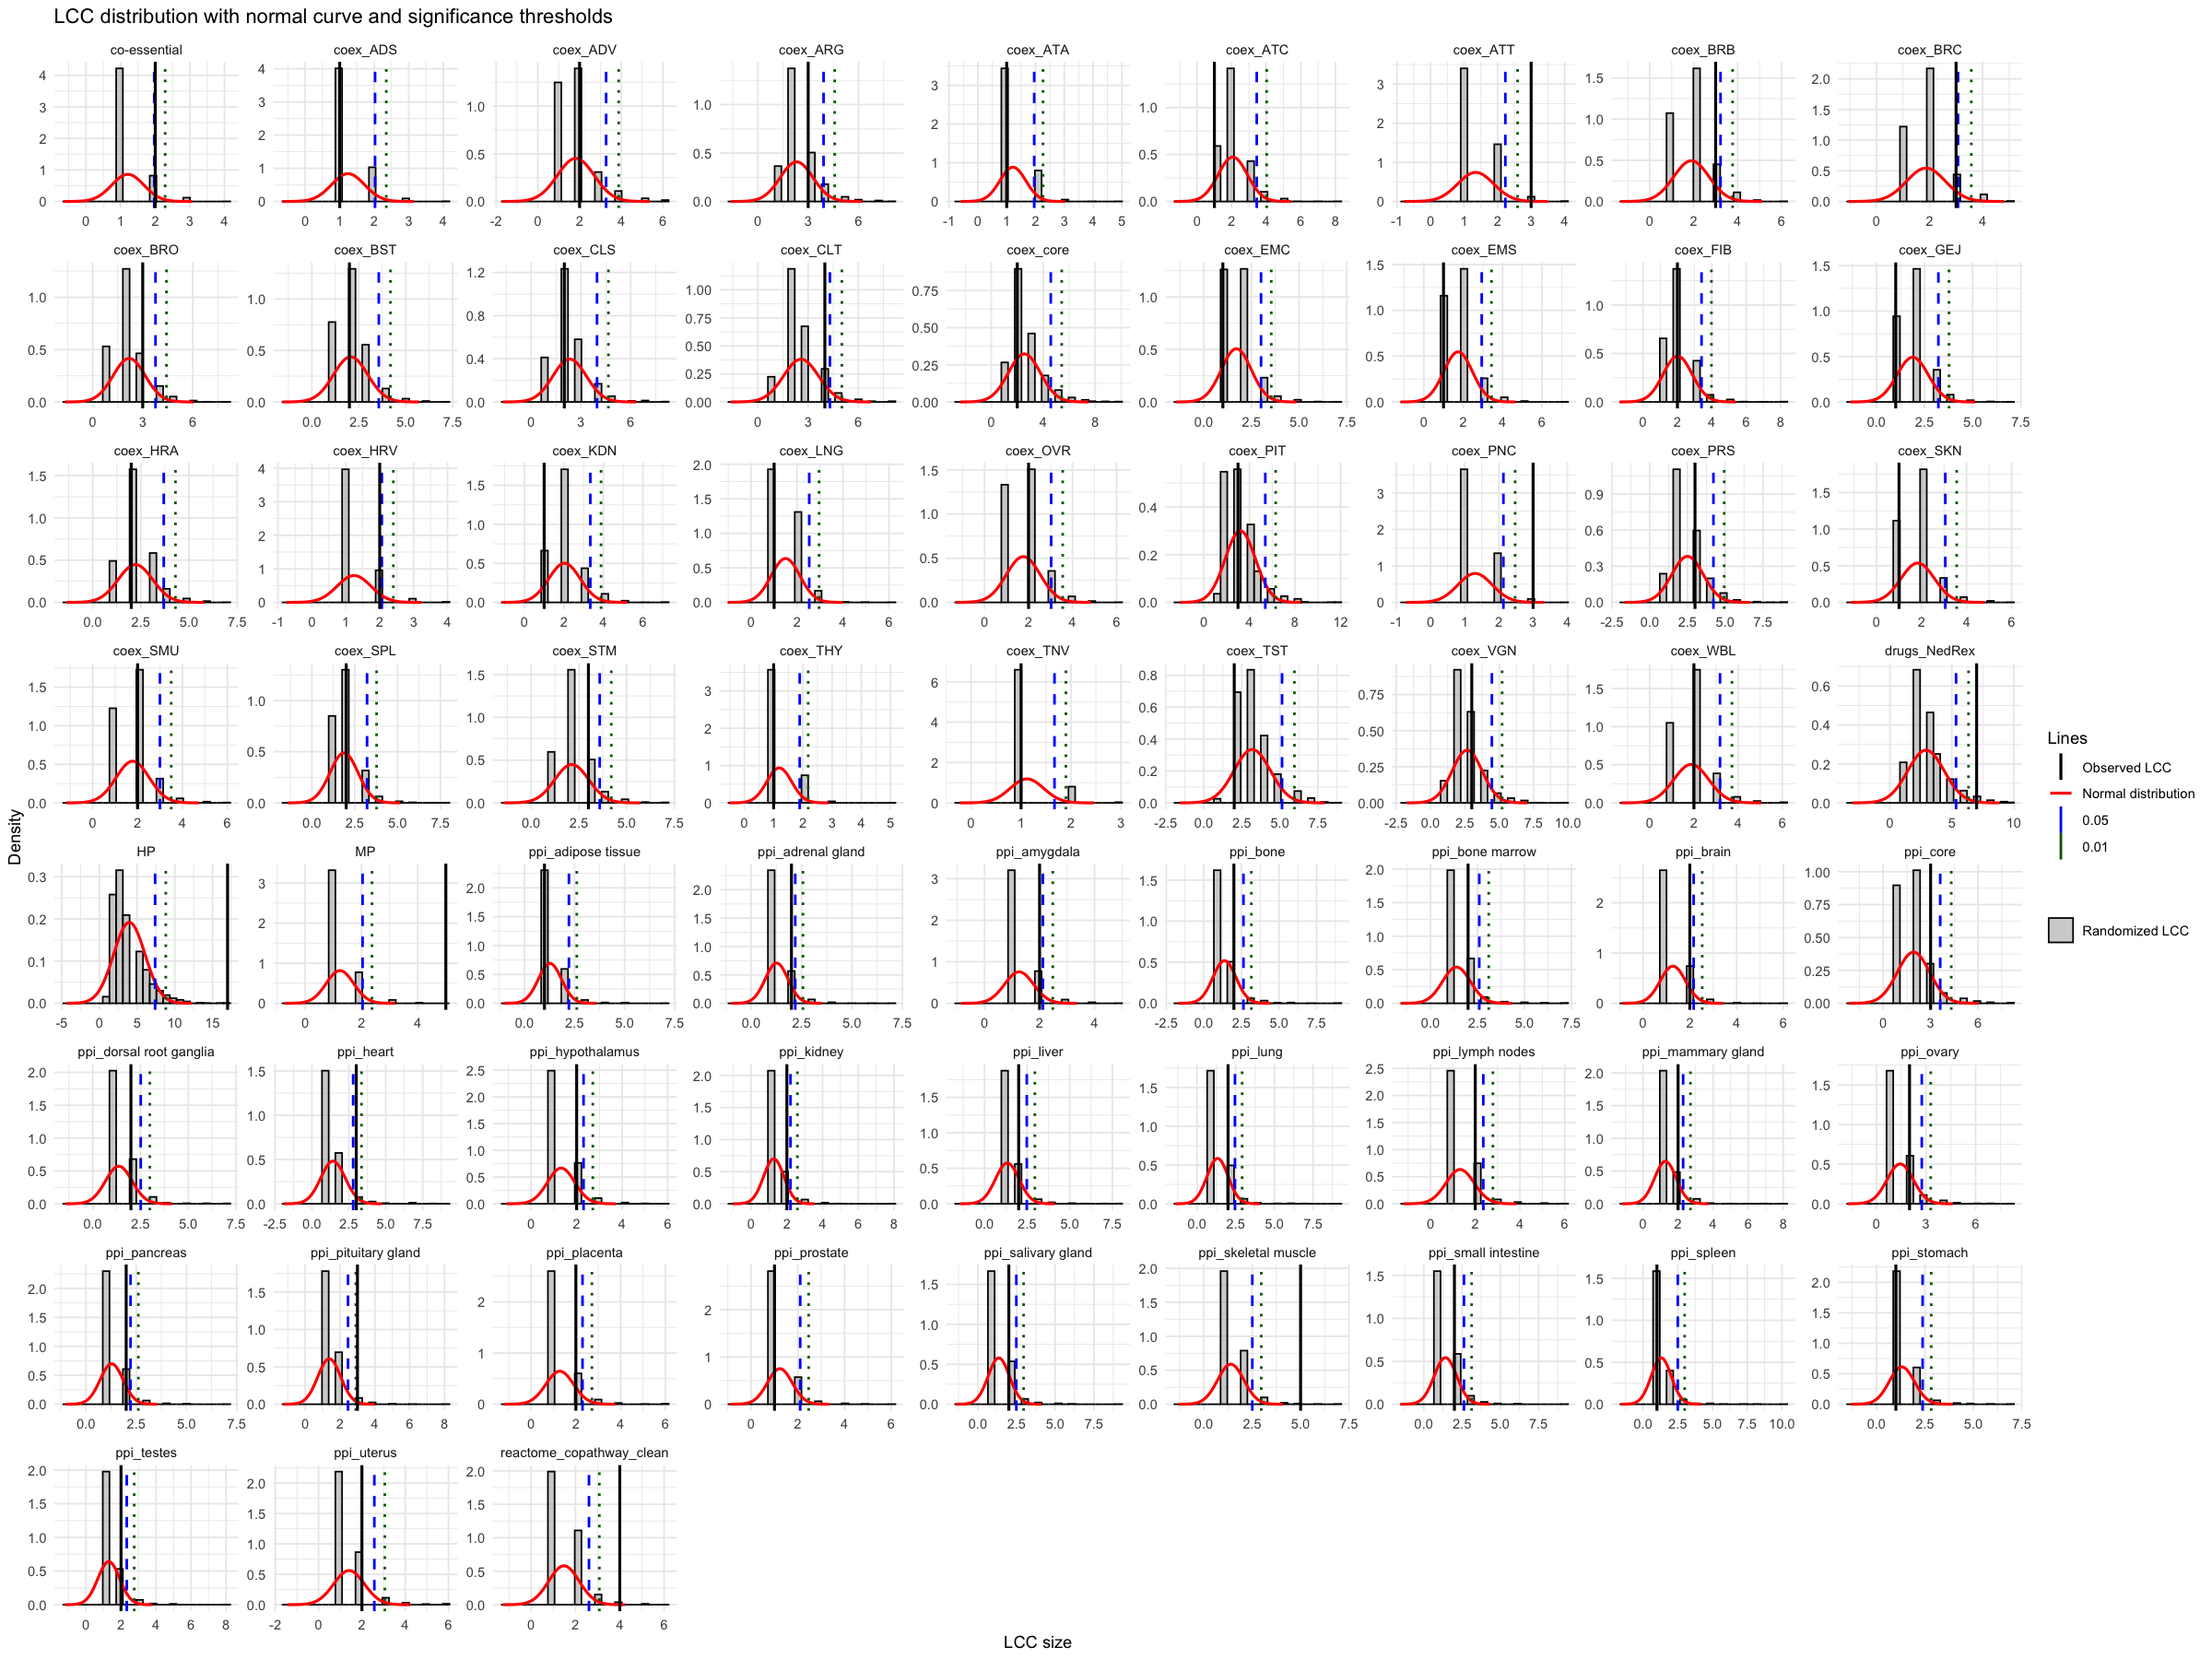

In [ ]:
options(repr.plot.width=20, repr.plot.height=15)
ggplot(hist_df, aes(x = value)) +

  # histogram: randomized LCC
  geom_histogram(
    aes(y = after_stat(density), fill = "Randomized LCC"),
    bins = 25,
    color = "black",
    alpha = 0.6
  ) +

  # normaldistribution 
  geom_line(
    data = norm_df,
    aes(x = x, y = y, color = "Normal distribution"),
    linewidth = 0.9
  ) +

  # significance border
  geom_vline(
    data = alpha_long,
    aes(xintercept = x, linetype = alpha, color = alpha),
    linewidth = 0.8
  ) +

  # observed LCC
  geom_vline(
    data = df,
    aes(xintercept = observed_lcc_size, color = "Observed LCC"),
    linewidth = 0.9
  ) +

  facet_wrap(~ network_name, scales = "free") +

  # explain colors
  scale_color_manual(
    name = "Lines",
    values = c(
      "Normal distribution" = "red",
      "Observed LCC" = "black",
      "0.05" = "blue",
      "0.01" = "darkgreen"
    ),
    breaks = c("Observed LCC", "Normal distribution", "0.05", "0.01")
  ) +

  # linetypes for α 
  scale_linetype_manual(
    values = c("0.05" = "dashed", "0.01" = "dotted")
  ) +

  # legend for histogram
  scale_fill_manual(
    name = "",
    values = c("Randomized LCC" = "grey70")
  ) +

 
  guides(linetype = "none") +

  theme_minimal() +
  theme(
    legend.position = "right",
    legend.box = "vertical"
  )+
  labs(
    x = "LCC size",
    y = "Density",
    title = "LCC distribution with normal curve and significance thresholds"
  )


In [8]:
 ggsave(
  "lcc_histogram_normal_grid.pdf",
  width = 16,
  height = 12
)

In [ ]:
# calculate significance borders with Bonferroni correction
alpha_df <- data.frame(
  network_name = df$network_name,

  alpha_05_bonf = df$mean_lcc_size +
    qnorm(1 - 0.05 / nrow(df)) * df$sd_lcc,

  alpha_01_bonf = df$mean_lcc_size +
    qnorm(1 - 0.01 / nrow(df)) * df$sd_lcc
)


In [ ]:
# prepare for plotting
alpha_long <- rbind(
  data.frame(
    network_name = alpha_df$network_name,
    alpha = "0.05 (Bonf.)",
    x = alpha_df$alpha_05_bonf
  ),
  data.frame(
    network_name = alpha_df$network_name,
    alpha = "0.01 (Bonf.)",
    x = alpha_df$alpha_01_bonf
  )
)


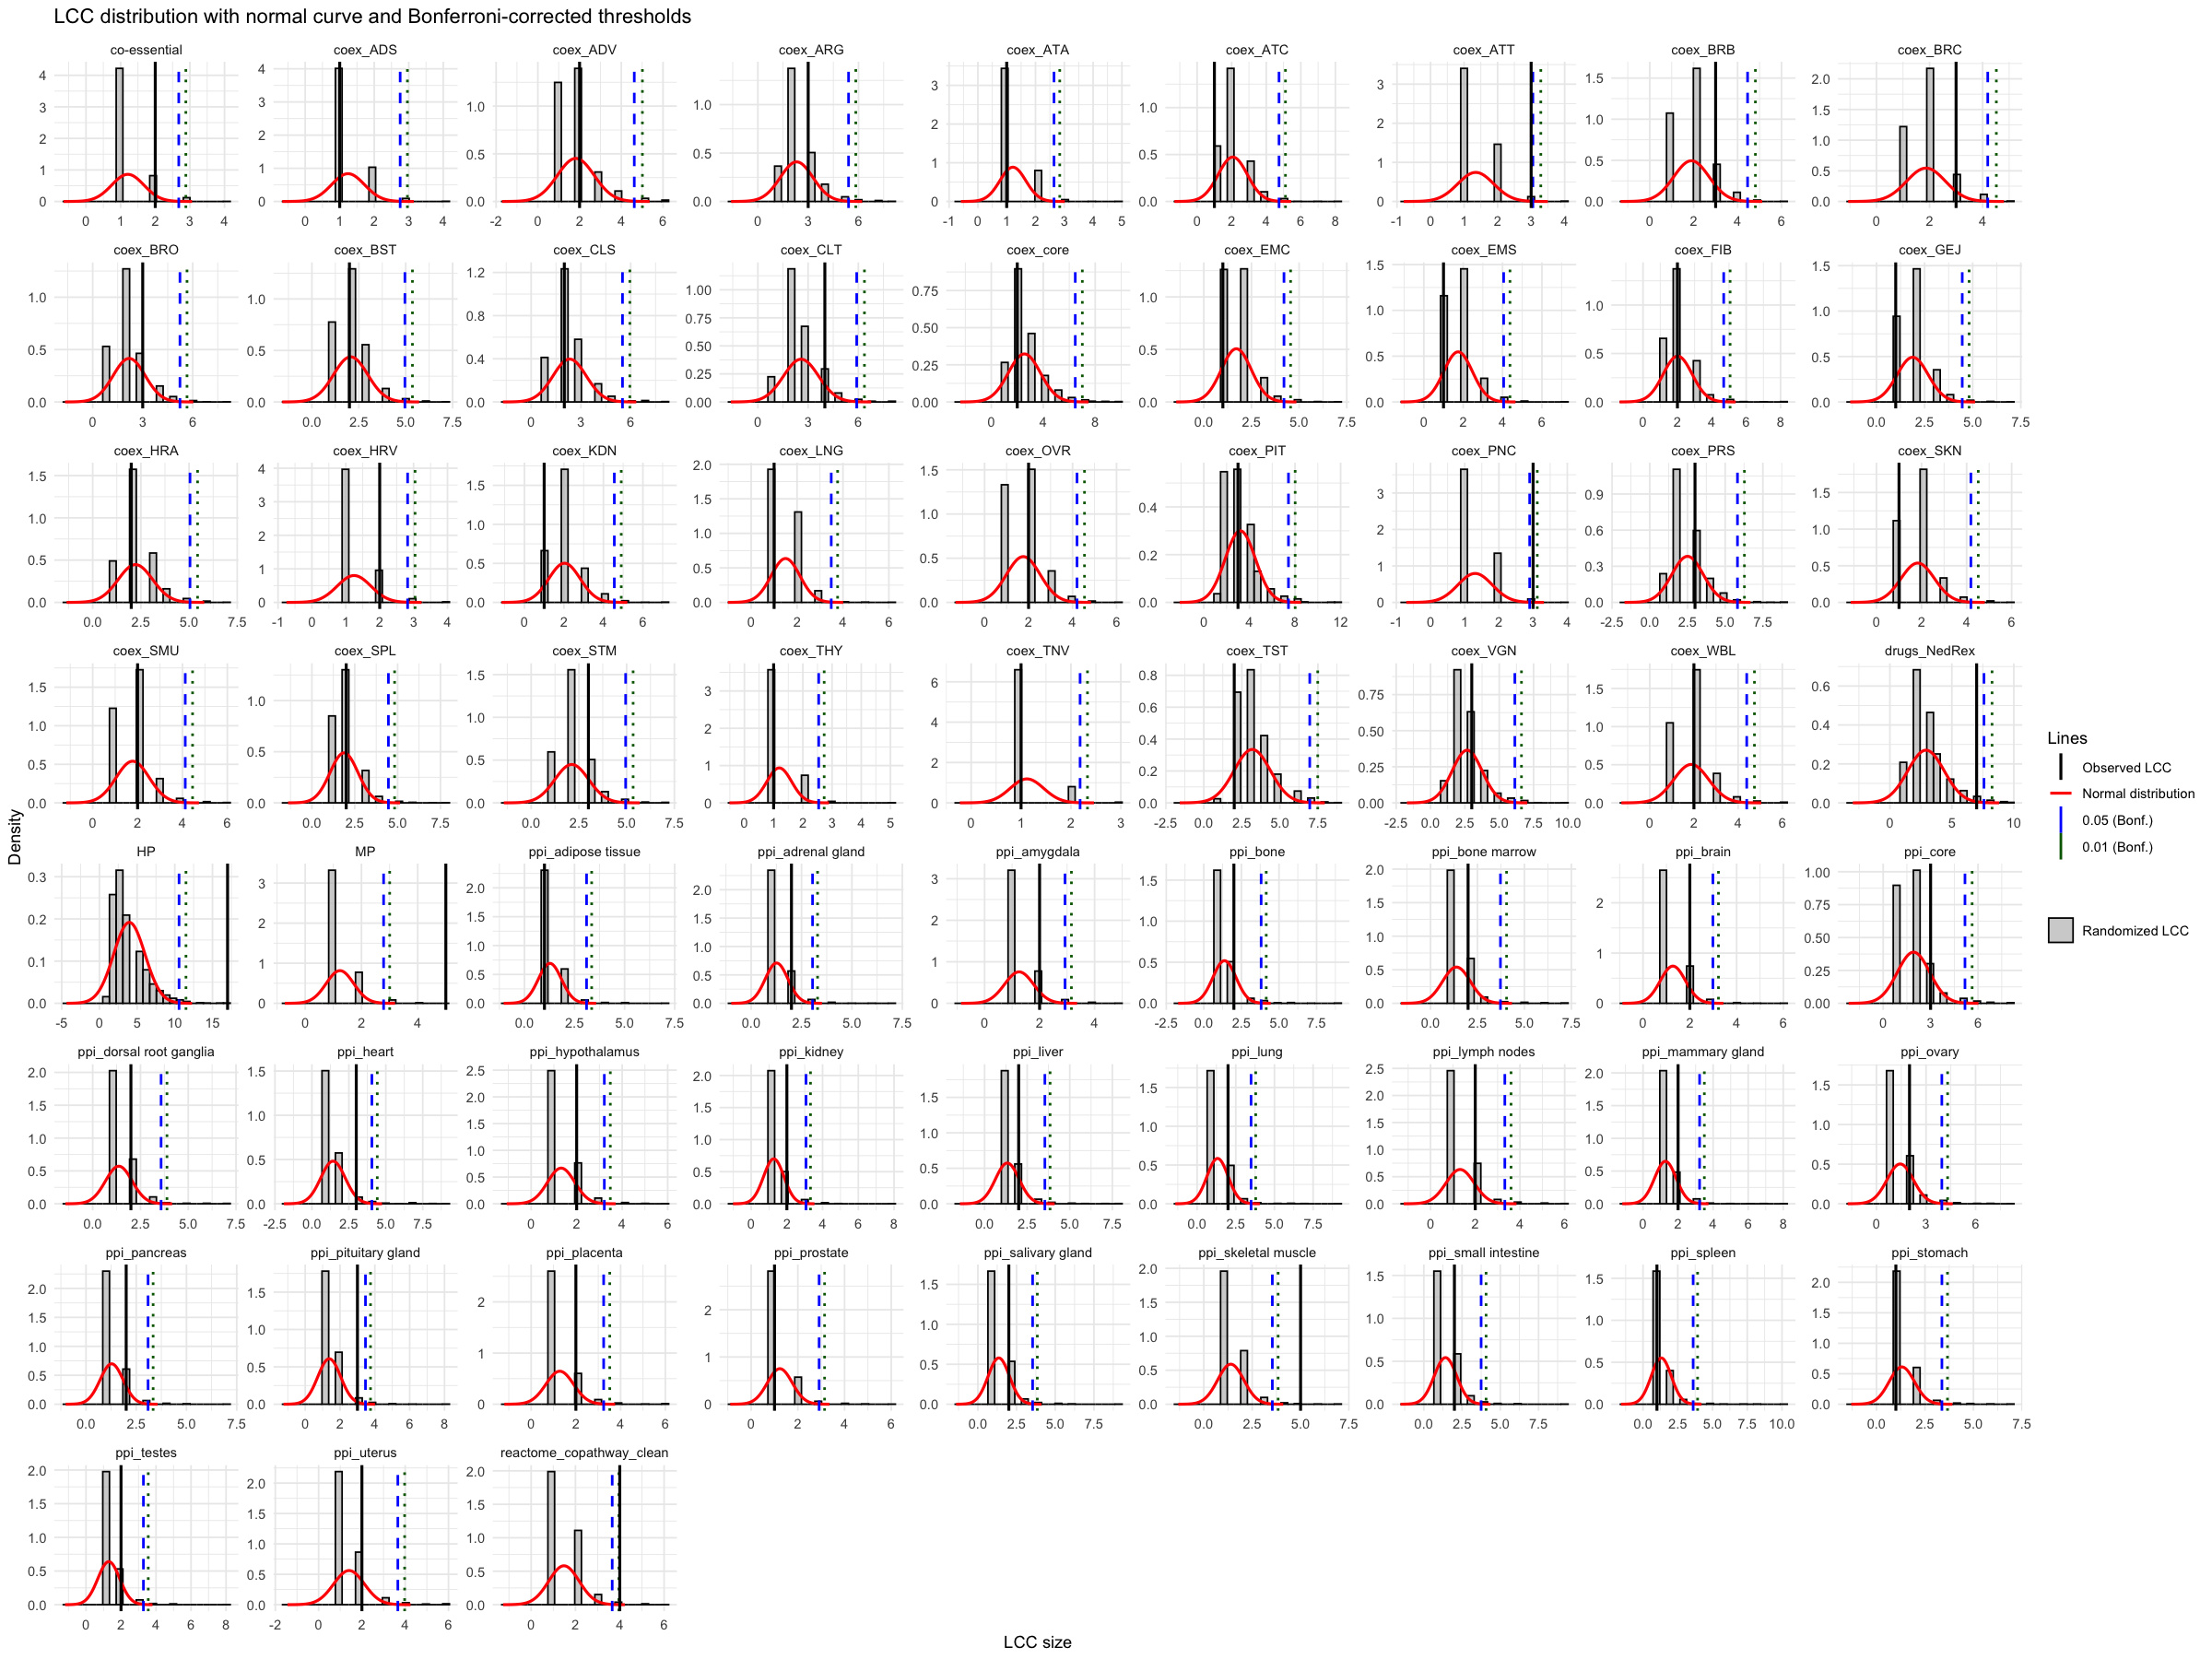

In [ ]:
options(repr.plot.width=20, repr.plot.height=15)
ggplot(hist_df, aes(x = value)) +

  # histogram: randomized LCC
  geom_histogram(
    aes(y = after_stat(density), fill = "Randomized LCC"),
    bins = 25,
    color = "black",
    alpha = 0.6
  ) +

  # normaldistribution 
  geom_line(
    data = norm_df,
    aes(x = x, y = y, color = "Normal distribution"),
    linewidth = 0.9
  ) +

  # Bonferroni significance borders
  geom_vline(
    data = alpha_long,
    aes(xintercept = x, linetype = alpha, color = alpha),
    linewidth = 0.8
  ) +

  # observed LCC
  geom_vline(
    data = df,
    aes(xintercept = observed_lcc_size, color = "Observed LCC"),
    linewidth = 0.9
  ) +

  facet_wrap(~ network_name, scales = "free") +

  # explain colors
  scale_color_manual(
    name = "Lines",
    values = c(
      "Normal distribution" = "red",
      "Observed LCC" = "black",
      "0.05 (Bonf.)" = "blue",
      "0.01 (Bonf.)" = "darkgreen"
    ),
    breaks = c(
      "Observed LCC",
      "Normal distribution",
      "0.05 (Bonf.)",
      "0.01 (Bonf.)"
    )
  ) +

  # linetypes
  scale_linetype_manual(
    values = c(
      "0.05 (Bonf.)" = "dashed",
      "0.01 (Bonf.)" = "dotted"
    )
  ) +

  # histogram legend
  scale_fill_manual(
    name = "",
    values = c("Randomized LCC" = "grey70")
  ) +

  
  guides(linetype = "none") +

  theme_minimal() +
  theme(
    legend.position = "right",
    legend.box = "vertical"
  ) +
  labs(
    x = "LCC size",
    y = "Density",
    title = "LCC distribution with normal curve and Bonferroni-corrected thresholds"
  )


In [12]:
 ggsave(
  "lcc_histogram_normal_grid_bonf.pdf",
  width = 16,
  height = 12
)

In [ ]:
# calculate alpha after bonferroni correction
alpha_bonf_0.05 <- 0.05/nrow(df)
alpha_bonf_0.01 <- 0.01/nrow(df)

In [ ]:
# test where the p value is lower than corrected alpha 
# filter (p < Bonferroni-α)
df_sig_bonf_005 <- df[df$p_value < alpha_bonf_0.05, ]
df_sig_bonf_001 <- df[df$p_value < alpha_bonf_0.01, ]
df_sig_bonf_005 
df_sig_bonf_001 


,network_name,lcc_size_distribution,observed_lcc_size,mean_lcc_size,sd_lcc,z_score,p_value
,<chr>,<I<list>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
25,coex_PNC,"1, 2, 2,....",3,1.304000,0.5030766,3.371256,3.741314e-04
37,HP,"4, 5, 2,....",17,3.967333,2.0800202,6.265644,1.856434e-10
38,MP,"1, 1, 2,....",5,1.234667,0.4896510,7.689831,7.327472e-15
60,ppi_skeletal muscle,"2, 1, 3,....",5,1.392667,0.6773370,5.325759,5.026630e-08
66,reactome_copathway_clean,"1, 1, 1,....",4,1.481333,0.6865123,3.668786,1.218524e-04


,network_name,lcc_size_distribution,observed_lcc_size,mean_lcc_size,sd_lcc,z_score,p_value
,<chr>,<I<list>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
37,HP,"4, 5, 2,....",17,3.967333,2.0800202,6.265644,1.856434e-10
38,MP,"1, 1, 2,....",5,1.234667,0.4896510,7.689831,7.327472e-15
60,ppi_skeletal muscle,"2, 1, 3,....",5,1.392667,0.6773370,5.325759,5.026630e-08
66,reactome_copathway_clean,"1, 1, 1,....",4,1.481333,0.6865123,3.668786,1.218524e-04


In [16]:
# export df of sig layers ( cols network_name & z_score)
df_sig<- df_sig_bonf_005[,c("network_name","z_score")]

write.csv(
  df_sig, 
  file = "/Users/paulinestaiber/Documents/Network/Pauline_Praktikum/lcc_sig_layer.csv",
  row.names = FALSE
)

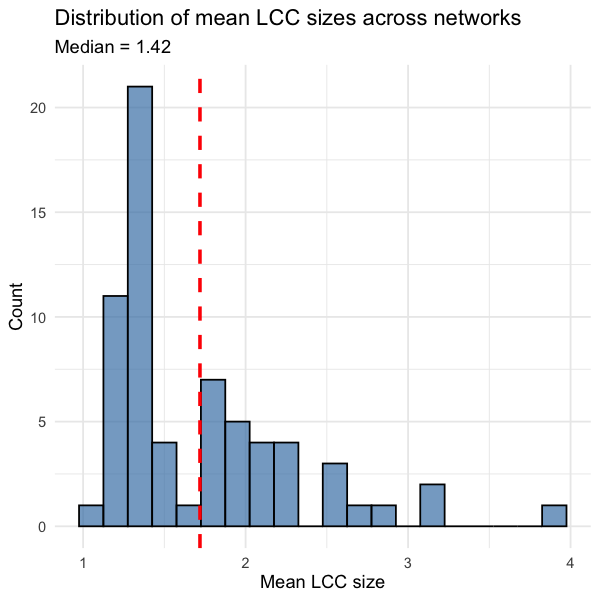

In [ ]:
# plot distribution of the means  
options(repr.plot.width=5, repr.plot.height=5)
ggplot(df, aes(x = mean_lcc_size)) +
  geom_histogram(bins = 20, fill = "steelblue", color = "black", alpha = 0.7) +
  geom_vline(aes(xintercept = mean(mean_lcc_size)), 
             color = "red", linetype = "dashed", linewidth = 1) +
  theme_minimal() +
  labs(
    x = "Mean LCC size",
    y = "Count",
    title = "Distribution of mean LCC sizes across networks",
    subtitle = paste("Median =", round(median(df$mean_lcc_size), 2))
  )

In [ ]:
# fit normal distribution to mean distribution
mean_lcc_vec <- df$mean_lcc_size

mu_means <- mean(mean_lcc_vec, na.rm = TRUE)
sd_means <- sd(mean_lcc_vec, na.rm = TRUE)

norm_df_means <- data.frame(
  x = seq(
    mu_means - 4 * sd_means,
    mu_means + 4 * sd_means,
    length.out = 300
  )
)
norm_df_means$y <- dnorm(norm_df_means$x, mean = mu_means, sd = sd_means)


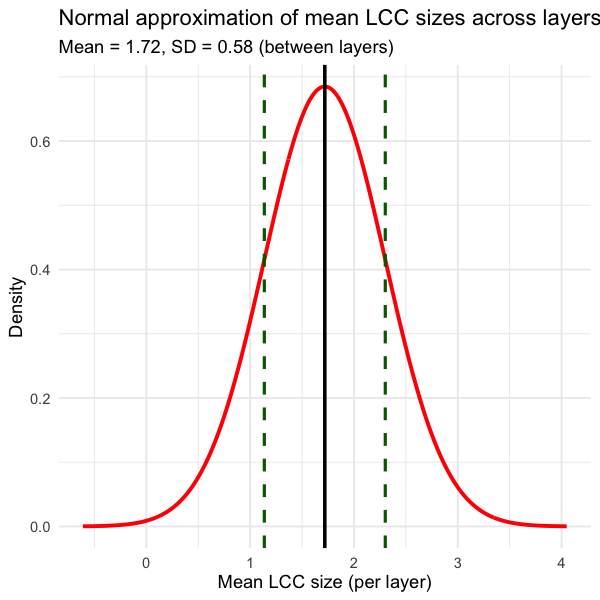

In [ ]:
ggplot(norm_df_means, aes(x = x, y = y)) +

  geom_line(
    color = "red",
    linewidth = 1.1
  ) +

  # mean
  geom_vline(
    xintercept = mu_means,
    color = "black",
    linewidth = 1
  ) +

  # ±1 SD
  geom_vline(
    xintercept = c(mu_means - sd_means, mu_means + sd_means),
    linetype = "dashed",
    color = "darkgreen",
    linewidth = 0.9
  ) +

  theme_minimal() +
  labs(
    x = "Mean LCC size (per layer)",
    y = "Density",
    title = "Normal approximation of mean LCC sizes across layers",
    subtitle = paste0(
      "Mean = ", round(mu_means, 2),
      ", SD = ", round(sd_means, 2),
      " (between layers)"
    )
  )


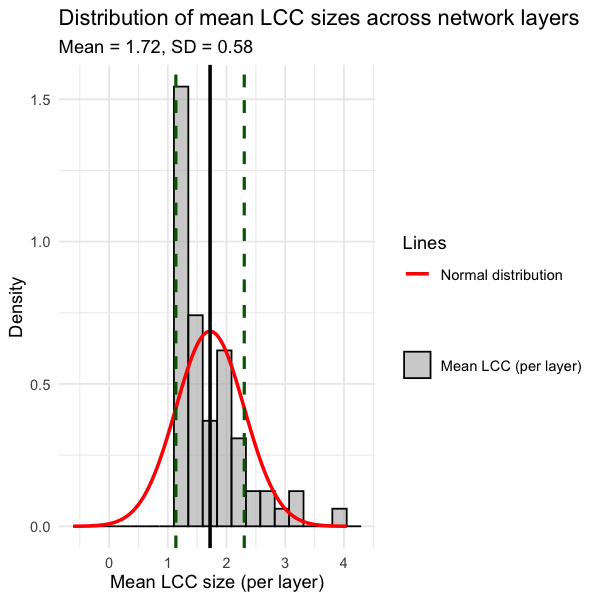

In [ ]:
ggplot(data.frame(mean_lcc = mean_lcc_vec),
       aes(x = mean_lcc)) +

  # histogram mean LCC
  geom_histogram(
    aes(y = after_stat(density), fill = "Mean LCC (per layer)"),
    bins = 20,
    color = "black",
    alpha = 0.6
  ) +

  # normalditribution
  geom_line(
    data = norm_df_means,
    aes(x = x, y = y, color = "Normal distribution"),
    linewidth = 1
  ) +

  # mean
  geom_vline(
    xintercept = mu_means,
    color = "black",
    linewidth = 1
  ) +

  # ±1 SD
  geom_vline(
    xintercept = c(mu_means - sd_means, mu_means + sd_means),
    linetype = "dashed",
    color = "darkgreen",
    linewidth = 0.9
  ) +

  scale_fill_manual(
    name = "",
    values = c("Mean LCC (per layer)" = "grey70")
  ) +

  scale_color_manual(
    name = "Lines",
    values = c("Normal distribution" = "red")
  ) +

  theme_minimal() +
  labs(
    x = "Mean LCC size (per layer)",
    y = "Density",
    title = "Distribution of mean LCC sizes across network layers",
    subtitle = paste0(
      "Mean = ", round(mu_means, 2),
      ", SD = ", round(sd_means, 2)
    )
  )


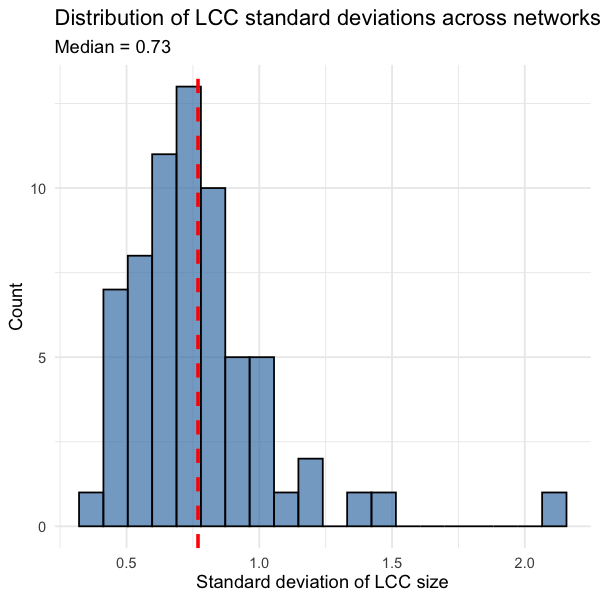

In [19]:
# distribution of the standard deviations

ggplot(df, aes(x = sd_lcc)) +
  geom_histogram(bins = 20, fill = "steelblue", color = "black", alpha = 0.7) +
  geom_vline(aes(xintercept = mean(sd_lcc)), 
             color = "red", linetype = "dashed", linewidth = 1) +
  theme_minimal() +
  labs(
    x = "Standard deviation of LCC size",
    y = "Count",
    title = "Distribution of LCC standard deviations across networks",
    subtitle = paste("Median =", round(median(df$sd_lcc), 2))
  )

In [22]:
# nodes per layer 
# edges per layer 
# ratio nodes/edges
layer_stats <- data.frame(
  layer = names(graph_list),
  nodes = sapply(graph_list, vcount),
  edges = sapply(graph_list, ecount)
)

layer_stats$edge_node_ratio <- layer_stats$edges / layer_stats$nodes
head(layer_stats)

,layer,nodes,edges,edge_node_ratio
,<chr>,<dbl>,<dbl>,<dbl>
co-essential,co-essential,3483,68813,19.756819
coex_ADS,coex_ADS,7737,66738,8.625824
coex_ADV,coex_ADV,9690,338981,34.982559
coex_ARG,coex_ARG,10388,654248,62.981132
coex_ATA,coex_ATA,9574,95939,10.020785
coex_ATC,coex_ATC,11209,485192,43.285931


In [23]:
layer_stats$layer <- factor(
  layer_stats$layer,
  levels = layer_stats$layer
)


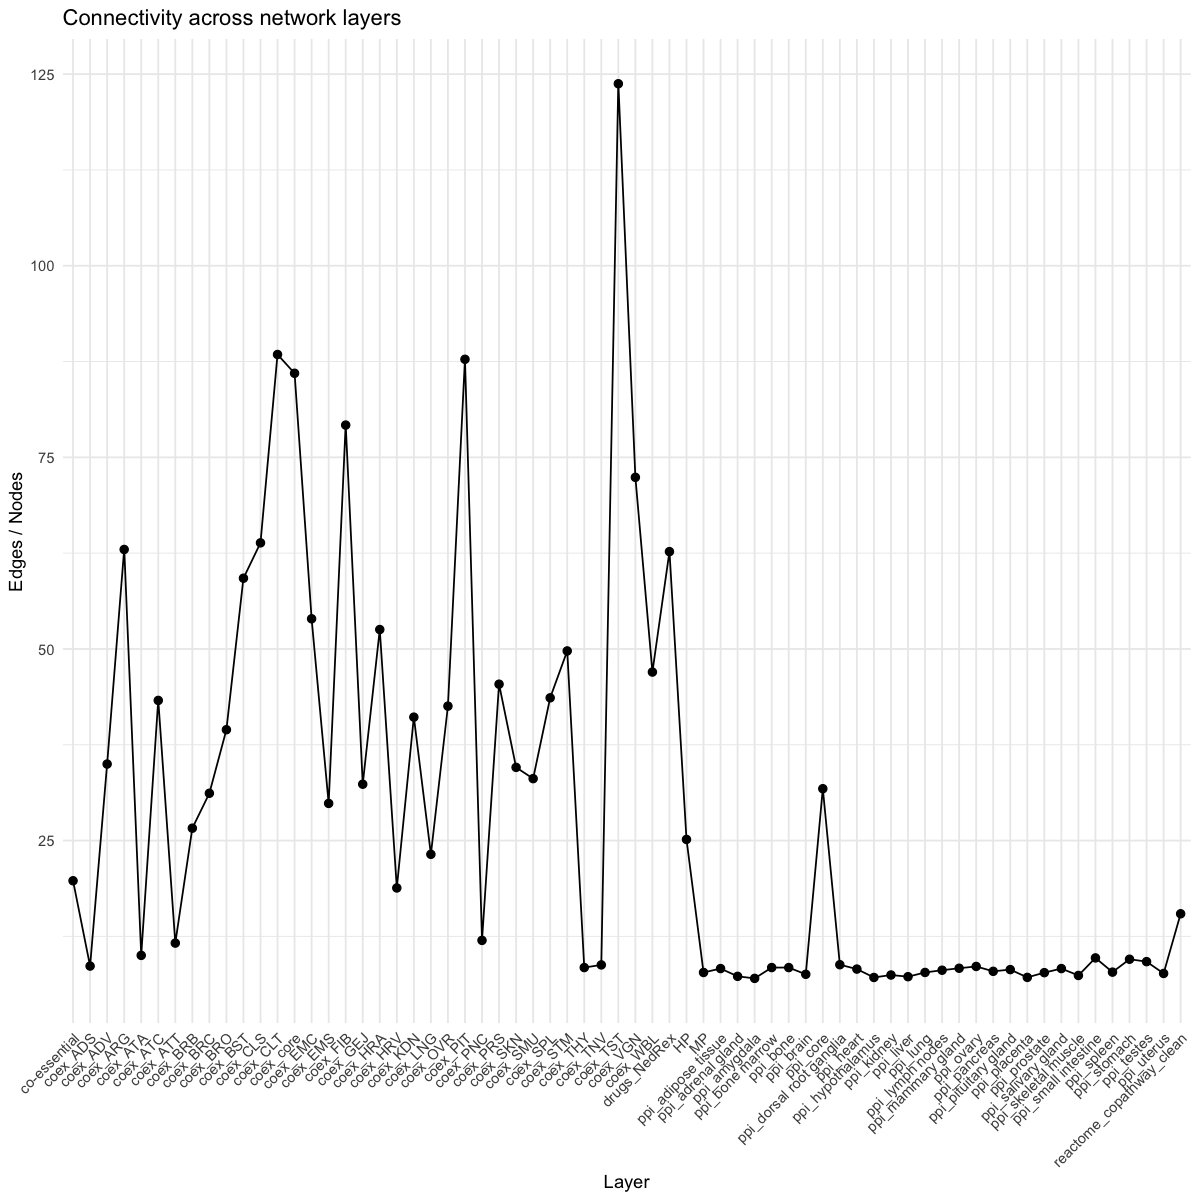

In [25]:
options(repr.plot.width=10, repr.plot.height=10)

p<- ggplot(layer_stats,
       aes(x = layer, y = edge_node_ratio, group = 1)) +
  geom_point(size = 2) +
  geom_line() +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
  ) +
  labs(
    x = "Layer",
    y = "Edges / Nodes",
    title = "Connectivity across network layers"
  )
ggsave(
  filename = "node_to_edge_ratio.png",
  plot = p,
  width = 20,   
  height = 8,
  dpi = 300
)
p

In [26]:
library(tidyr)

layer_stats_long <- layer_stats %>%
  pivot_longer(
    cols = c(nodes, edges),
    names_to = "metric",
    values_to = "value"
  )


In [ ]:
p<-ggplot(layer_stats_long,
       aes(x = layer, y = value, group = metric)) +
  geom_point(size = 2) +
  geom_line() +
  facet_wrap(~ metric, scales = "free_y", ncol = 1) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
  ) +
  labs(
    x = "Layer",
    y = "",
    title = "Network size across layers"
  )
ggsave(
  filename = "network_size_across_layers_wide.png",
  plot = p,
  width = 20,   # ⬅️ DAS ist die X-Achse
  height = 8,
  dpi = 300
)
p